In [1]:
import numpy as np
import pandas as pd
import os
import datetime
import random as random
from keras import backend as K
import pathlib
import glob
import datetime as dt
from functools import reduce
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')


Mounted at /content/drive


In [102]:

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
def accuracie(y_pred,y_test):
    y_true = y_test # Your real values / test labels

    print('Mean Absolute Error (MAE)            :', metrics.mean_absolute_error(y_true, y_pred))
    print('Mean Squared Error (MSE)             :', metrics.mean_squared_error(y_true, y_pred))
    print('Root Mean Squared Error (RMSE)       :', metrics.mean_squared_error(y_true, y_pred, squared=False))
    print('Explained Variance Score             :', metrics.explained_variance_score(y_true, y_pred))
    print('R^2                                  :', metrics.r2_score(y_true, y_pred))
    return{'Mean Absolute Error (MAE)': metrics.mean_absolute_error(y_true, y_pred),'Mean Squared Error (MSE)': metrics.mean_squared_error(y_true, y_pred),
           'Root Mean Squared Error (RMSE)': metrics.mean_squared_error(y_true, y_pred, squared=False),'Explained Variance Score': metrics.explained_variance_score(y_true, y_pred),'R^2': metrics.r2_score(y_true, y_pred)}


# Visualising the Random Forest Regression results
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def plot_please(y_pred,y_test):
    plt.figure(figsize=(24,10))
    plt.plot(range(len(y_test)), y_test,color = 'red')   
    plt.plot(range(len(y_pred)), y_pred, color = 'cyan',marker='o',linestyle="--") 
    plt.title('Random Forest Regression')
    plt.xlabel('Sample over time')
    plt.ylabel('Load')
    return(plt.show())

def calculate_vif(X_train):   
   # VIF dataframe
   vif_data = pd.DataFrame()
   # calculating VIF for each feature
   vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
   vif_data.index = X_train.columns.values
   return(print(vif_data["VIF"])) 

from sklearn.decomposition import PCA
def apply_pca(df2,x,columns):
     pca = PCA(x)
     X_train = pca.fit_transform(df2)
     df02=pd.DataFrame(X_train,columns=columns)
     return(df02)

def create_SM_features(df_dataset,N=list(range(2, 24,1))):
    list_dummy=[]
    df_n_hourly_sum=pd.DataFrame() 
    for n in N:               #pass N as list   
        df_dataset.index=pd.to_datetime(df_dataset.index)
        tisa  = str(n)+"H"
        col   = "MeanLast_"+tisa
        df_n_hourly_sum[col] = df_dataset.resample(tisa).transform('sum')
    df_n_hourly_sum["day"]=[i.day for i in df_dataset.index]
    df_n_hourly_sum["month"]=[i.month for i in df_dataset.index]
    df_n_hourly_sum["hour"]=[i.hour for i in df_dataset.index]
    df_n_hourly_sum["weekday"]=[i.weekday() for i in df_dataset.index]
    df_n_hourly_sum["week"]=[i.week for i in df_dataset.index]
    return df_n_hourly_sum


from pandas import concat
#Function to generate forecasting data
#n_in=1 ,for n>1 just manage the loop's   
def series_to_supervised(df, n_in=1, n_out=1):
        n_vars = 1 
        # df = pd.DataFrame(data)
        cols, names = [],[] 
        # input sequence (t-n, ... t-1)
        for i in range(n_in,0,-1):
                cols.append(df.shift(i))
                names.append(str('lag'+str(i)))       #names.append([lambda x:'var%d(t-%d)'%(x+1, i)) range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        # for i in range(0, n_out):
        #         cols.append(df.shift(-i))
        #         names.append("lag"+str(i+2))
        #print(names)
        agg = concat(cols, axis=1)
        agg.columns=names 
        agg.index=pd.to_datetime(df.index.values)
        agg["year"]=agg.index.year
        agg["month"]=agg.index.month
        agg["hour"]=agg.index.hour
        agg["day"]=agg.index.day
        agg["weekday"]=agg.index.weekday
        agg["weekoftheyear"]=agg.index.week
        # drop rows with NaN values
        agg.dropna(inplace=True)
        return agg
# 


In [4]:
hourly_path= "/content/drive/MyDrive/dataset/Hourly_data.csv"
dataset_hourly=pd.read_csv(hourly_path)

In [5]:
dataset_hourly=dataset_hourly.set_index("hour")
dataset_hourly=dataset_hourly.iloc[:,1:]

In [6]:
dataset_hourly.describe()

,MAC000246,MAC004179,MAC004247,MAC004319,MAC004387,MAC004431,MAC000323,MAC000713,MAC000768,MAC000778,...,MAC001893,MAC001989,MAC002025,MAC002150,MAC002314,MAC002628,MAC002937,MAC003072,MAC003110,MAC004529
count,14533.000000,14533.000000,14533.000000,14533.000000,14533.000000,14533.000000,14533.000000,14533.000000,14533.000000,14533.000000,...,14533.000000,14533.000000,14533.000000,14533.000000,14533.000000,14533.000000,14533.000000,14533.000000,14533.000000,14533.000000
mean,0.779961,4.262406,0.921553,2.056699,0.182428,0.903560,0.671657,0.475631,0.491378,0.841433,...,0.772533,0.863946,0.386655,0.565719,0.614398,2.000586,0.598486,0.712492,0.331485,0.320925
std,0.874300,1.455437,0.613571,1.673837,0.155960,0.646749,0.683589,0.481757,0.397692,0.953678,...,0.764114,1.022796,0.310096,0.547905,0.593839,1.281375,0.418419,0.559562,0.281825,0.332850
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.156000,3.291000,0.436000,0.914000,0.102000,0.498000,0.235000,0.163000,0.167000,0.233000,...,0.213000,0.169000,0.175000,0.218000,0.164000,1.031000,0.348000,0.286000,0.169000,0.115000
50%,0.441000,3.914000,0.749000,1.571000,0.126000,0.697000,0.377000,0.311000,0.435000,0.476000,...,0.507000,0.427000,0.269000,0.352000,0.354000,1.561000,0.453000,0.462000,0.228000,0.184000
75%,1.138000,4.853000,1.346000,2.520000,0.208000,1.070000,0.868000,0.557000,0.658000,1.144000,...,1.078000,1.020000,0.512000,0.674000,0.918000,2.773000,0.685000,1.043000,0.397000,0.406000
max,6.160000,15.275000,6.636000,13.678000,2.334000,6.420000,6.360000,5.391000,2.774000,8.970000,...,9.260000,6.090000,3.530000,4.376000,3.428000,12.681000,6.536000,4.181000,6.580000,3.314000


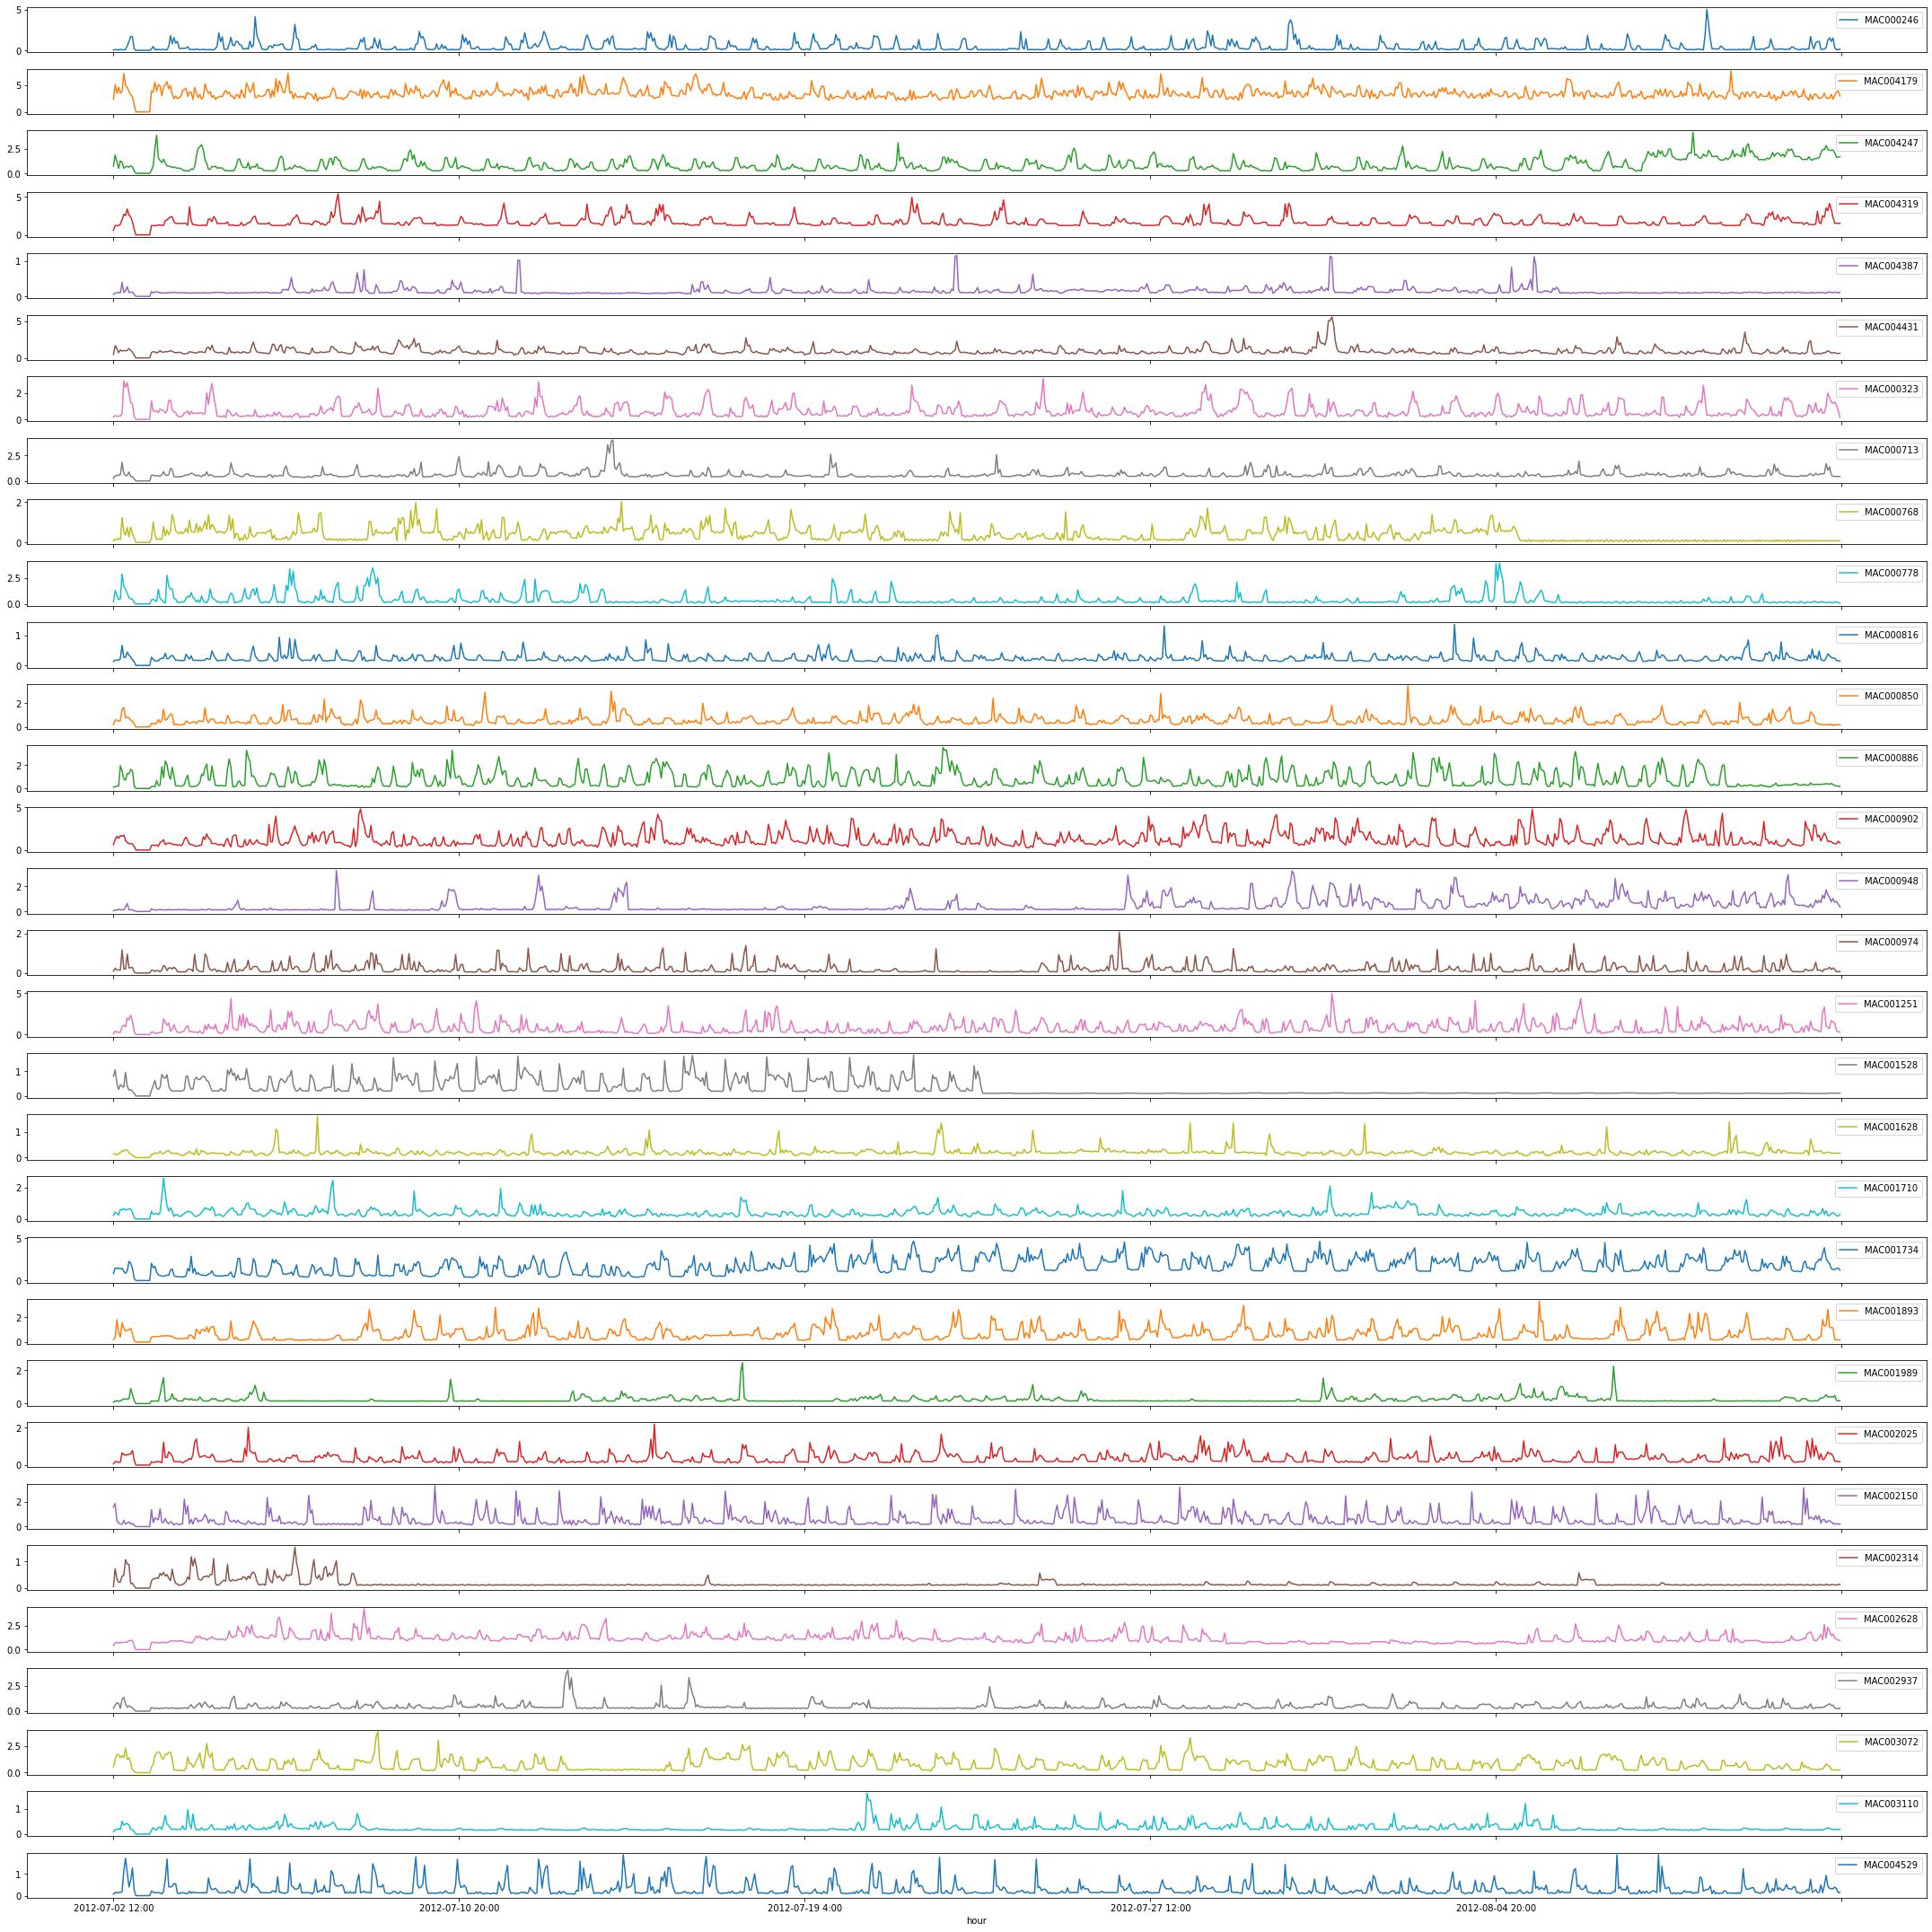

In [ ]:
dataset_hourly.iloc[:1000,:].plot(subplots=True,figsize=(30,30))

plt.tight_layout()
plt.show()

# Using Single user data for training 

### Training to Forecast : User MAC001710 Load : using every other user for training a model


In [7]:
user_list=list(dataset_hourly.columns.values )

In [19]:
def data_loader(data,train=1,user_list=list(user_list)):
    if train==1:
        X,y=[],[]
        n_past=24
        for user in user_list: 
                y.append(dataset_hourly[user][:-int(n_past)])
                X.append((series_to_supervised(pd.DataFrame(data[user],index=dataset_hourly.index).sort_index(ascending=False),n_past)).sort_index(ascending=True))
        return  X,y
    if train==2:
        X,y=[],[]
        n_past=24
        for user in user_list: 
                y.append(dataset_hourly[user])
                X.append((create_SM_features(pd.DataFrame(data[user],index=dataset_hourly.index).sort_index(ascending=False))).sort_index(ascending=True))
        return  X,y
   

In [20]:
X,y=data_loader(dataset_hourly.sort_index(ascending=False))

<ipython-input-18-631f404c5875>:123: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  agg["weekoftheyear"]=agg.index.week


In [21]:
np.array(X).shape,np.array(y).shape

((31, 14509, 30), (31, 14509))

#Training 31 models : Each model trained on single user

# Model : Random Forest

In [ ]:
model_list,pred_list=[],[]

for index,user in enumerate(user_list):    
    X_train=X[index]
    y_train=y[index]
    ## Random Forest
    regressor = RandomForestRegressor(n_estimators = 10, oob_score=True ,n_jobs=10,verbose=2)
    # fit the regressor with x and y data
    print("MODEL:",index)
    regressor.fit(X_train, y_train)
    pred_list.append(regressor.oob_prediction_)
    model_list.append(regressor)

In [ ]:
len(model_list)  #one extra model deleted later

31

In [ ]:
list1,list2=[],[]
for index,user in enumerate(user_list):
     list3=[model_list[index].predict(X[i]) for i in range(len(user_list))] 
     list4=[accuracie(list3[i].reshape(-1,1),y[i])  for i in range(len(user_list))]
     list1.append(list4)


In [ ]:
result=pd.DataFrame(list1,columns=user_list,index=user_list)

In [ ]:
list21,list22,list23,list24=[],[],[],[]
for i in result.values:
    list21.append([j['Root Mean Squared Error (RMSE)'] for j in i])
    list22.append([j['Explained Variance Score'] for j in i])
    list23.append([j['Mean Squared Error (MSE)'] for j in i])
    list24.append([j["R^2"] for j in i])

In [ ]:
pd.DataFrame(np.array(list24),columns=user_list,index=user_list)

,MAC000246,MAC004179,MAC004247,MAC004319,MAC004387,MAC004431,MAC000323,MAC000713,MAC000768,MAC000778,...,MAC001893,MAC001989,MAC002025,MAC002150,MAC002314,MAC002628,MAC002937,MAC003072,MAC003110,MAC004529
MAC000246,0.999997,0.780482,0.999930,0.924766,1.000000,0.999969,0.999978,0.999999,1.000000,0.997016,...,0.997164,0.999997,1.000000,0.999999,0.999999,0.987980,0.999878,0.999999,0.999736,1.000000
MAC004179,0.947228,0.999969,0.818407,0.985644,0.464409,0.815239,0.901158,0.808041,0.638639,0.944918,...,0.926650,0.967558,0.532400,0.829650,0.893869,0.978849,0.570466,0.826869,0.567287,0.705661
MAC004247,0.997400,0.650820,0.999957,0.882571,0.860179,0.999202,0.997975,0.991256,0.993182,0.990223,...,0.991007,0.994391,0.984640,0.997731,0.995726,0.965526,0.999396,0.999549,0.976976,0.977178
MAC004319,0.993582,0.999780,0.999749,0.999993,0.593287,0.999630,0.992102,0.972596,0.970858,0.997279,...,0.992383,0.994114,0.928604,0.984775,0.983420,0.999997,0.999198,0.994624,0.894709,0.931386
MAC004387,0.855265,-1.931757,0.931242,0.310625,0.999863,0.906087,0.935078,0.959122,0.998010,0.809396,...,0.877267,0.821268,0.995466,0.967734,0.990247,0.460373,0.951245,0.982365,0.960053,0.997795
MAC004431,0.998449,0.770279,0.999886,0.921293,0.869598,0.999956,0.999285,0.997615,0.994252,0.996501,...,0.996393,0.999471,0.994488,0.999649,0.997722,0.986685,0.999894,0.999890,0.996762,0.981360
MAC000323,0.998588,0.582476,0.999433,0.858688,0.995045,0.999083,0.999945,0.999892,0.999791,0.989405,...,0.992650,0.999818,0.999945,0.999995,0.999944,0.968545,0.999045,0.999998,0.998415,0.999312
MAC000713,0.996248,0.454265,0.998854,0.820540,0.998807,0.997243,0.999270,0.999789,0.999697,0.983636,...,0.987466,0.998497,0.999983,0.999965,0.999993,0.952725,0.997927,0.999969,0.997700,0.999830
MAC000768,0.915635,-1.140152,0.968604,0.464136,0.999958,0.955632,0.972055,0.983207,0.999997,0.878941,...,0.927108,0.908152,0.998901,0.991510,0.998874,0.658813,0.975189,0.995697,0.978764,0.999518
MAC000778,0.999992,0.948324,0.999996,0.983141,0.999998,0.999997,0.999998,0.999999,0.999999,0.999969,...,0.999785,0.999997,1.000000,0.999999,0.999999,0.997905,0.999999,0.999999,0.999950,0.999999


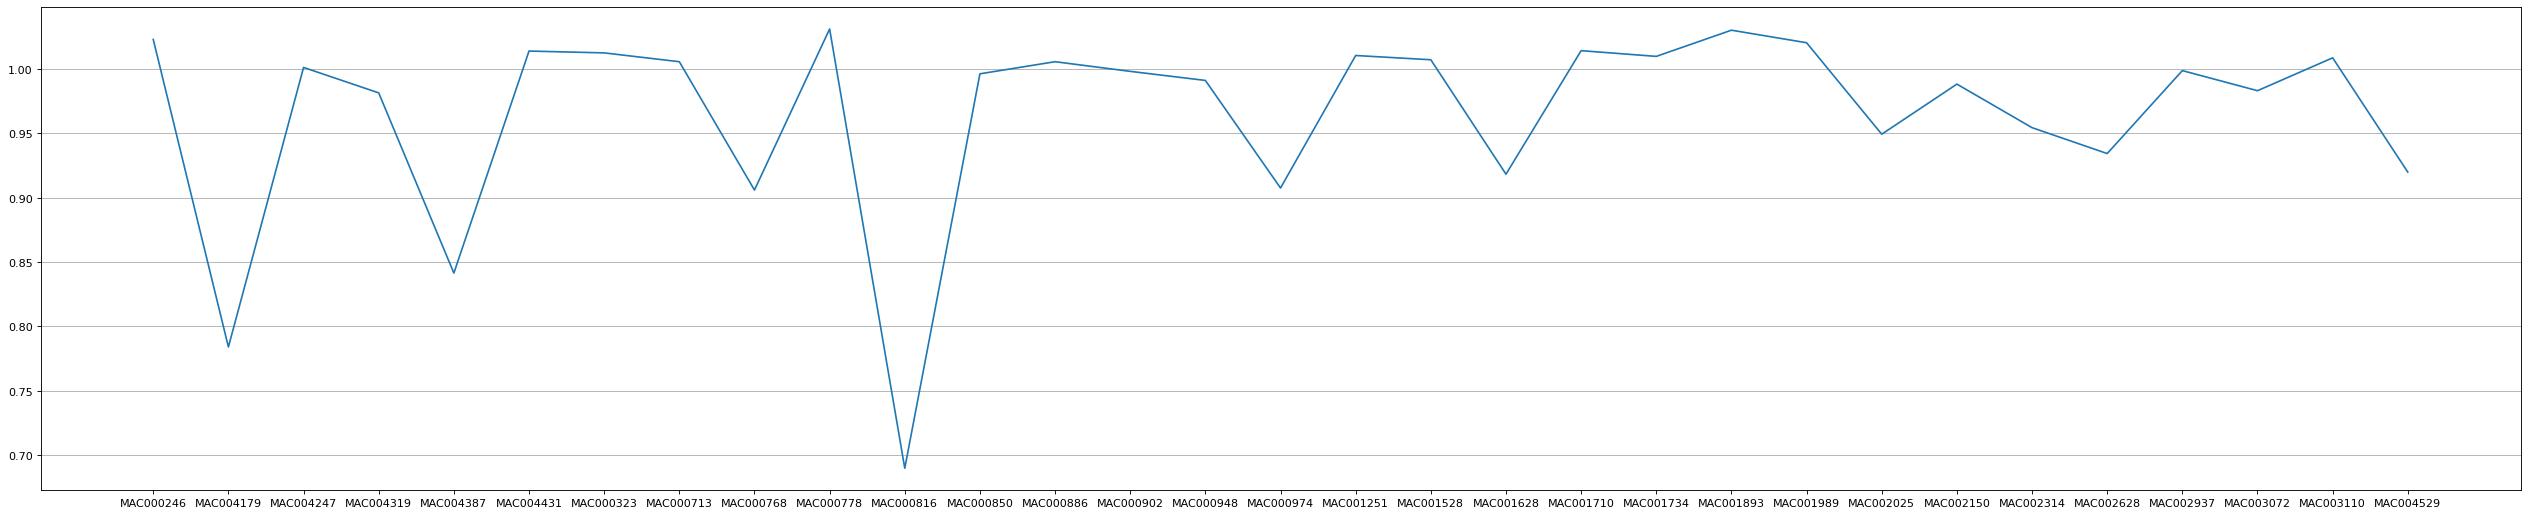

In [ ]:
### Which user(train data) model performed well on maximum users
from matplotlib.pyplot import figure
figure(figsize=(40, 8), dpi=80)

k=pd.DataFrame(pd.DataFrame(np.array(list24),columns=user_list,index=user_list).sum(axis=1)/30,columns=["sum"])
plt.plot( k.index,k["sum"].values)
plt.grid(axis='y',)
plt.show()

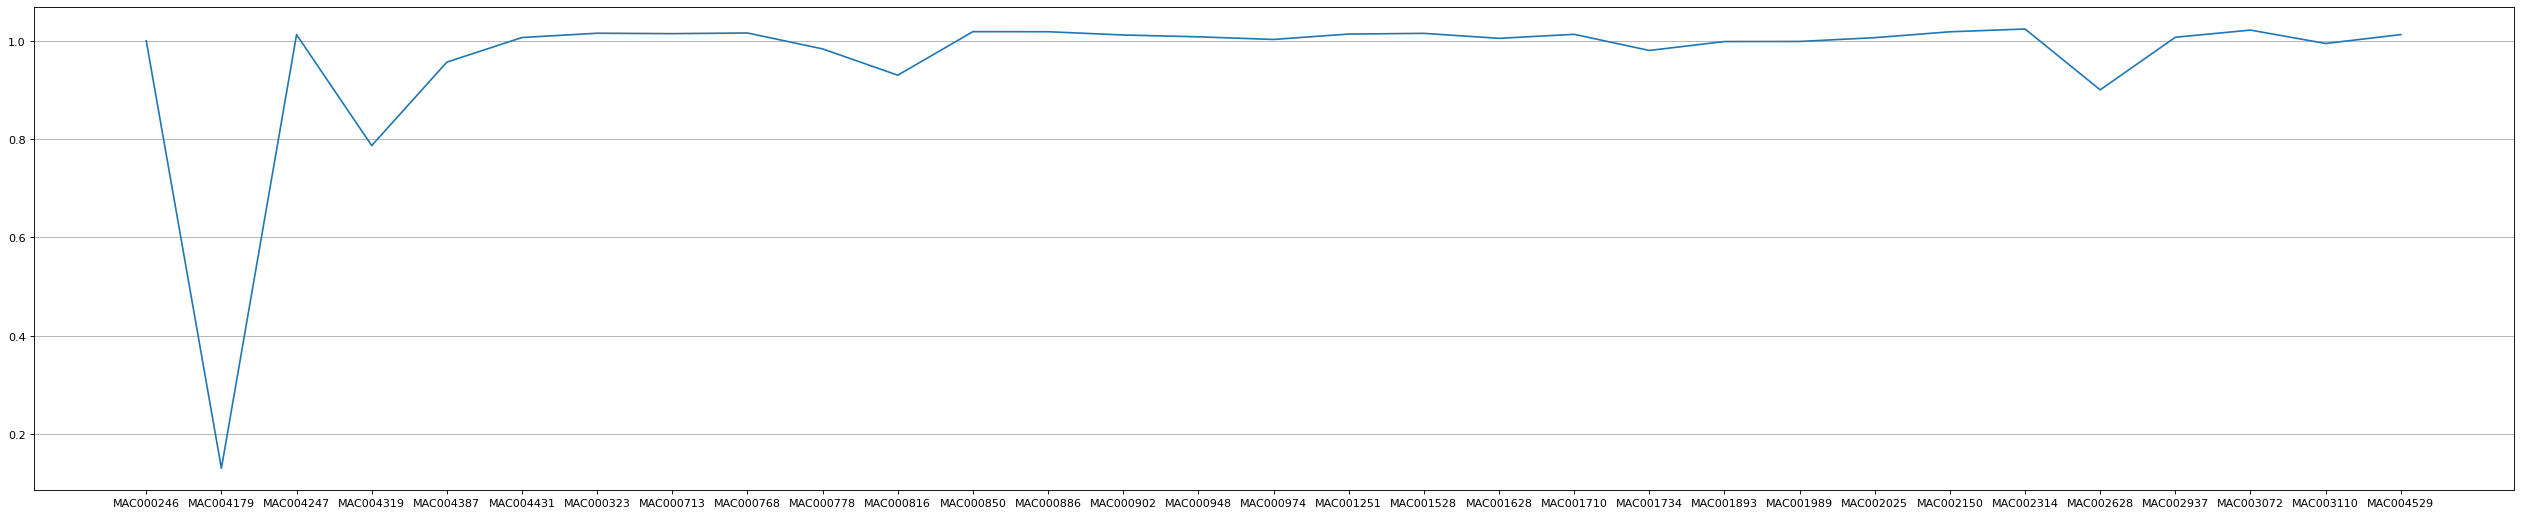

In [ ]:
### which user data(test) was well forecasted by all models 
k=pd.DataFrame(pd.DataFrame(np.array(list24),columns=user_list,index=user_list).sum(axis=0)/30,columns=["sum"])
figure(figsize=(40, 8), dpi=80)
plt.plot( k.index,k["sum"].values)
plt.grid(axis='y',)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.


<Figure size 2400x800 with 0 Axes>

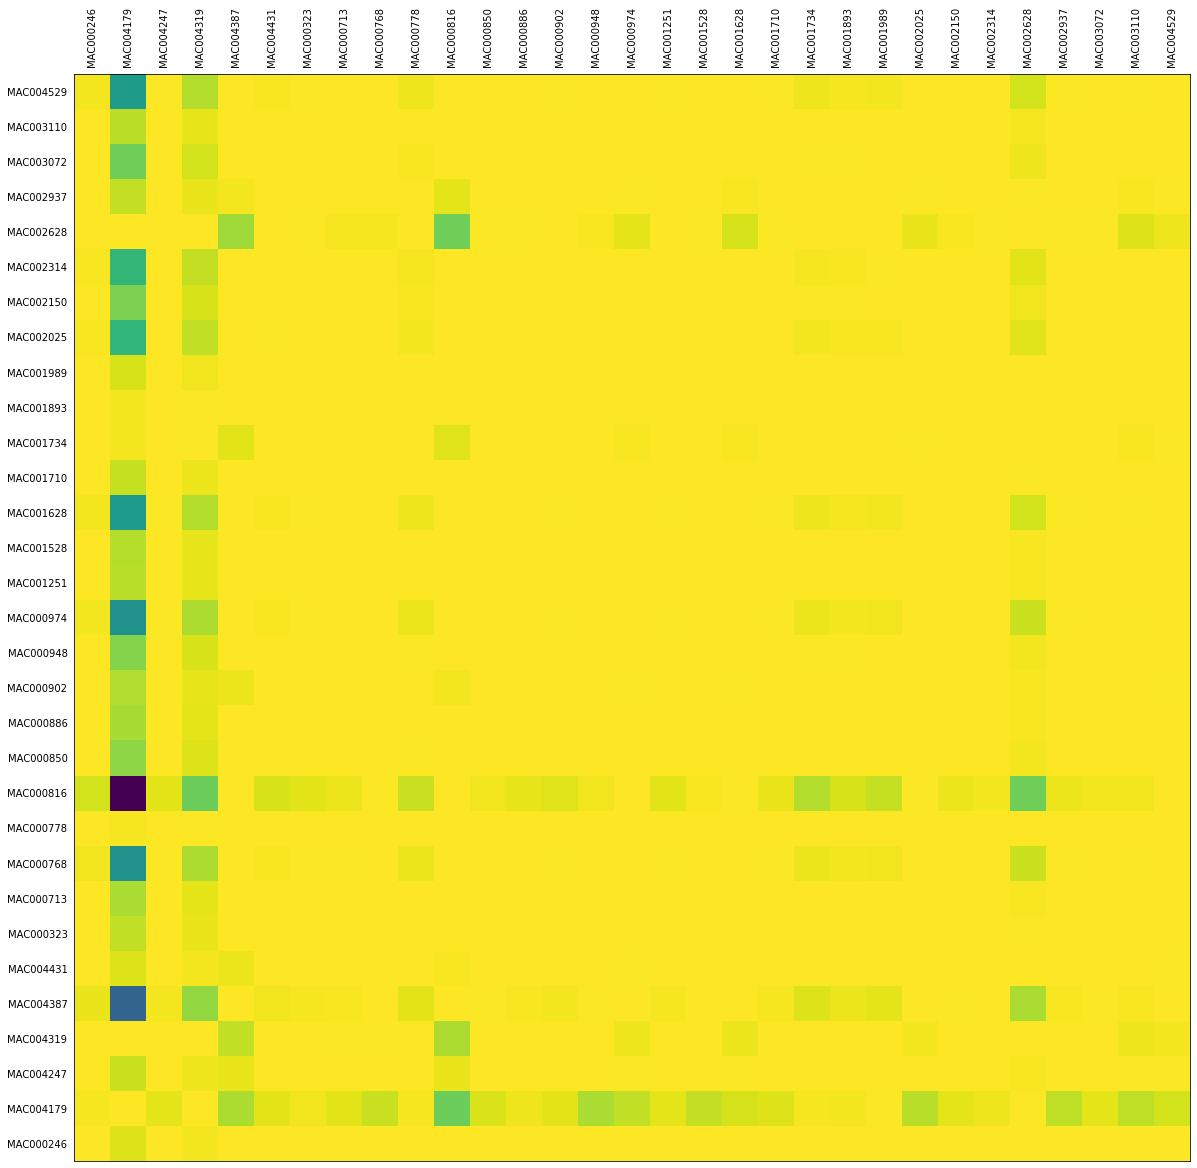

In [ ]:
xlabels=user_list
ylabels=user_list
data=pd.DataFrame(np.array(list24),columns=user_list,index=user_list)
figure(figsize=(30, 10), dpi=80)
fig, ax = plt.subplots(figsize=(20, 20))

ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)

ax.xaxis.tick_top()
plt.xticks(rotation=90)

ax.set_xticklabels(xlabels, minor=False)
ax.set_yticklabels(ylabels, minor=False)
heatmap = ax.pcolor(data)

ax = plt.gca()

for t in ax.xaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False
for t in ax.yaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False

plt.show()

#Using same model and user architecture 
#with different dataset having custom features

In [ ]:
X,y=data_loader(dataset_hourly.sort_index(ascending=False),2)

In [ ]:
np.array(X).shape,np.array(y).shape

((31, 14533, 27), (31, 14533))

In [ ]:
X[4].head()

,MeanLast_2H,MeanLast_3H,MeanLast_4H,MeanLast_5H,MeanLast_6H,MeanLast_7H,MeanLast_8H,MeanLast_9H,MeanLast_10H,MeanLast_11H,...,MeanLast_19H,MeanLast_20H,MeanLast_21H,MeanLast_22H,MeanLast_23H,day,month,hour,weekday,week
hour,,,,,,,,,,,,,,,,,,,,,
2012-07-02 12:00:00,0.151,0.251,0.364,0.251,0.86,0.151,0.364,0.86,1.132,1.517,...,0.969,1.132,1.407,1.517,1.637,28,2,0,4,9
2012-07-02 13:00:00,0.151,0.251,0.364,0.251,0.86,0.151,0.364,0.86,1.132,1.517,...,0.969,1.132,1.407,1.517,1.637,27,2,9,3,9
2012-07-02 14:00:00,0.213,0.251,0.364,0.251,0.86,1.256,0.364,0.86,1.132,1.517,...,0.969,1.132,1.407,1.517,1.637,27,2,8,3,9
2012-07-02 15:00:00,0.213,0.609,0.364,0.881,0.86,1.256,0.364,0.86,1.132,1.517,...,0.969,1.132,1.407,1.517,1.637,27,2,7,3,9
2012-07-02 16:00:00,0.496,0.609,0.768,0.881,0.86,1.256,1.391,0.86,1.132,1.517,...,0.969,1.132,1.407,1.517,1.637,27,2,6,3,9


In [ ]:
model_list,pred_list=[],[]

for index,user in enumerate(user_list):    
    X_train=X[index]
    y_train=y[index]
    ## Random Forest
    regressor = RandomForestRegressor(n_estimators = 10, oob_score=True ,n_jobs=10,verbose=2)
    # fit the regressor with x and y data
    print("MODEL:",index)
    regressor.fit(X_train, y_train)
    pred_list.append(regressor.oob_prediction_)
    model_list.append(regressor)

In [ ]:
len(model_list)

31

In [ ]:
list1,list2=[],[]
for index,user in enumerate(user_list):
     list3=[model_list[index].predict(X[i]) for i in range(len(user_list))] 
     list4=[accuracie(list3[i].reshape(-1,1),y[i])  for i in range(len(user_list))]
     list1.append(list4)

In [ ]:
result=pd.DataFrame(list1,columns=user_list,index=user_list)
list21,list22,list23,list24=[],[],[],[]
for i in result.values:
    list24.append([j["R^2"] for j in i])

In [ ]:
## Columns are result from individual models
pd.DataFrame(np.array(list24),columns=user_list,index=user_list)

,MAC000246,MAC004179,MAC004247,MAC004319,MAC004387,MAC004431,MAC000323,MAC000713,MAC000768,MAC000778,...,MAC001893,MAC001989,MAC002025,MAC002150,MAC002314,MAC002628,MAC002937,MAC003072,MAC003110,MAC004529
MAC000246,0.968858,0.525805,0.818881,0.801484,0.773370,0.868143,0.889466,0.836639,0.783404,0.862503,...,0.842355,0.872708,0.749951,0.675548,0.904895,0.893742,0.773223,0.882807,0.769998,0.772526
MAC004179,0.650093,0.969404,0.528013,0.888529,-0.798799,0.574668,0.616764,0.387584,0.144421,0.710619,...,0.666258,0.732756,-0.183589,0.302981,0.664923,0.907267,0.010874,0.517903,-0.302854,0.184884
MAC004247,0.826959,0.503839,0.974752,0.806919,0.605239,0.874269,0.877399,0.827939,0.767876,0.852870,...,0.852549,0.873052,0.736672,0.663745,0.906584,0.901977,0.784258,0.867222,0.728360,0.713434
MAC004319,0.819649,0.875038,0.838452,0.980827,0.321639,0.882802,0.861108,0.798724,0.750358,0.859831,...,0.841348,0.864122,0.649963,0.630618,0.891364,0.940134,0.776505,0.850263,0.594816,0.644681
MAC004387,0.588256,-3.648373,0.612100,-0.053943,0.947399,0.555377,0.685545,0.718993,0.722221,0.535157,...,0.607971,0.529920,0.689519,0.631077,0.818648,-0.088607,0.643092,0.766851,0.689093,0.765175
MAC004431,0.832491,0.575183,0.854380,0.841106,0.619733,0.977822,0.900091,0.844240,0.798731,0.869439,...,0.856495,0.874864,0.741898,0.686015,0.908302,0.909391,0.820045,0.899395,0.742167,0.736867
MAC000323,0.846996,0.412108,0.851684,0.774262,0.787032,0.901815,0.974022,0.859092,0.810426,0.866320,...,0.860899,0.884155,0.777862,0.693458,0.921785,0.897597,0.823516,0.912318,0.800740,0.763657
MAC000713,0.831019,0.219376,0.837496,0.769030,0.786044,0.881525,0.891698,0.958075,0.810773,0.853866,...,0.856536,0.858584,0.786270,0.687125,0.919025,0.818105,0.815701,0.896635,0.800142,0.766919
MAC000768,0.732199,-2.241141,0.794213,0.236687,0.782959,0.796841,0.830760,0.818388,0.950257,0.708229,...,0.761927,0.735538,0.780339,0.684452,0.905827,0.360204,0.775338,0.872875,0.760070,0.779871
MAC000778,0.843907,0.749396,0.848643,0.900438,0.780532,0.898849,0.897944,0.848354,0.804016,0.966660,...,0.856666,0.894394,0.767137,0.682506,0.911116,0.917170,0.808016,0.895964,0.796076,0.793708


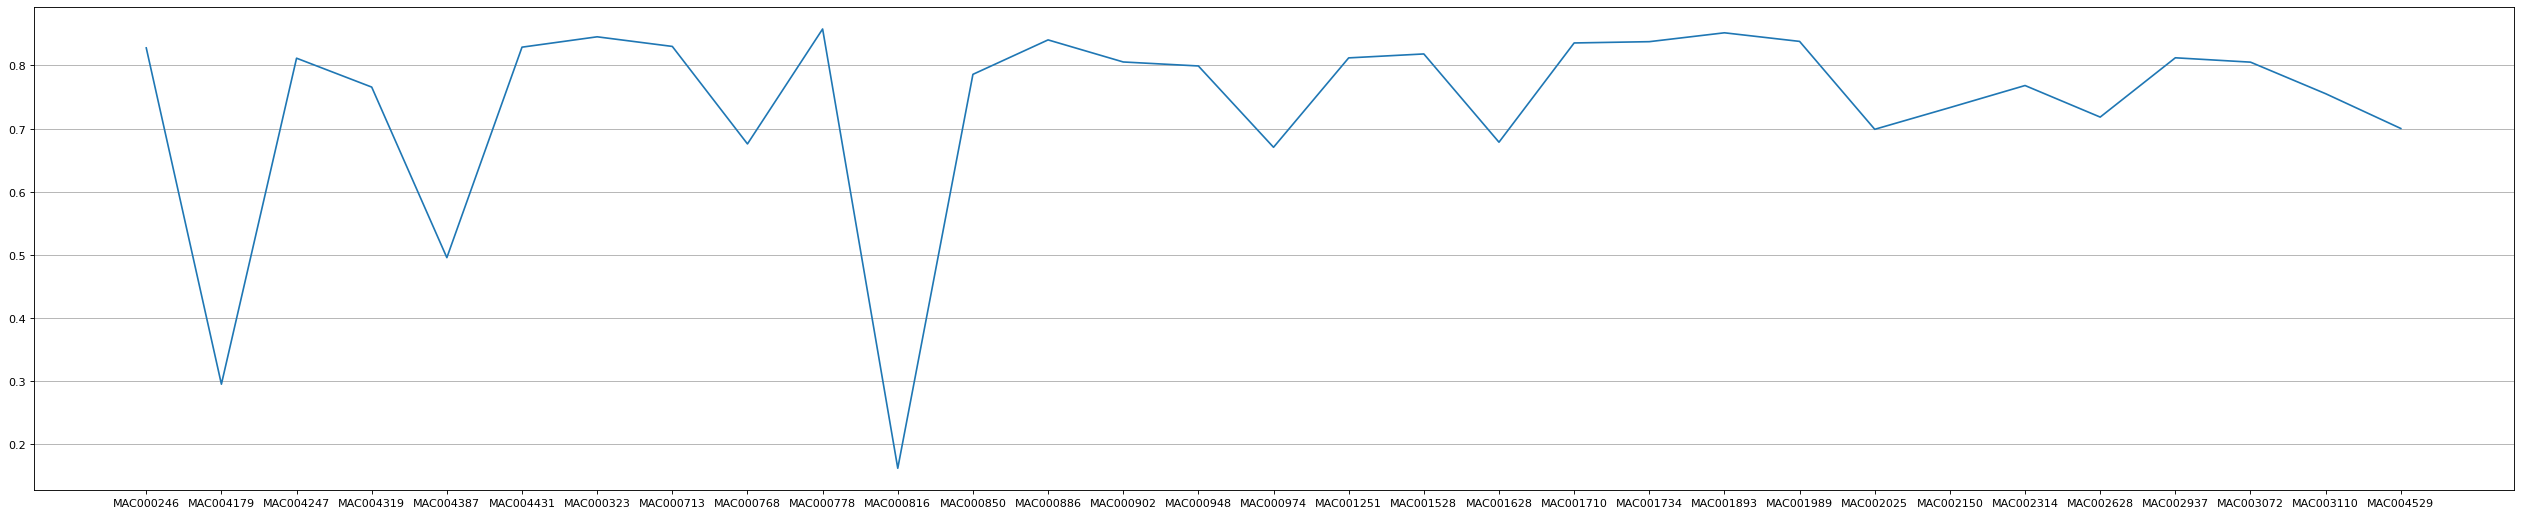

In [ ]:
### Which model performed well on each maximum users data
figure(figsize=(40, 8), dpi=80)

k=pd.DataFrame(pd.DataFrame(np.array(list24),columns=user_list,index=user_list).sum(axis=1)/30,columns=["sum"])
plt.plot( k.index,k["sum"].values)
plt.grid(axis='y',)
plt.show()

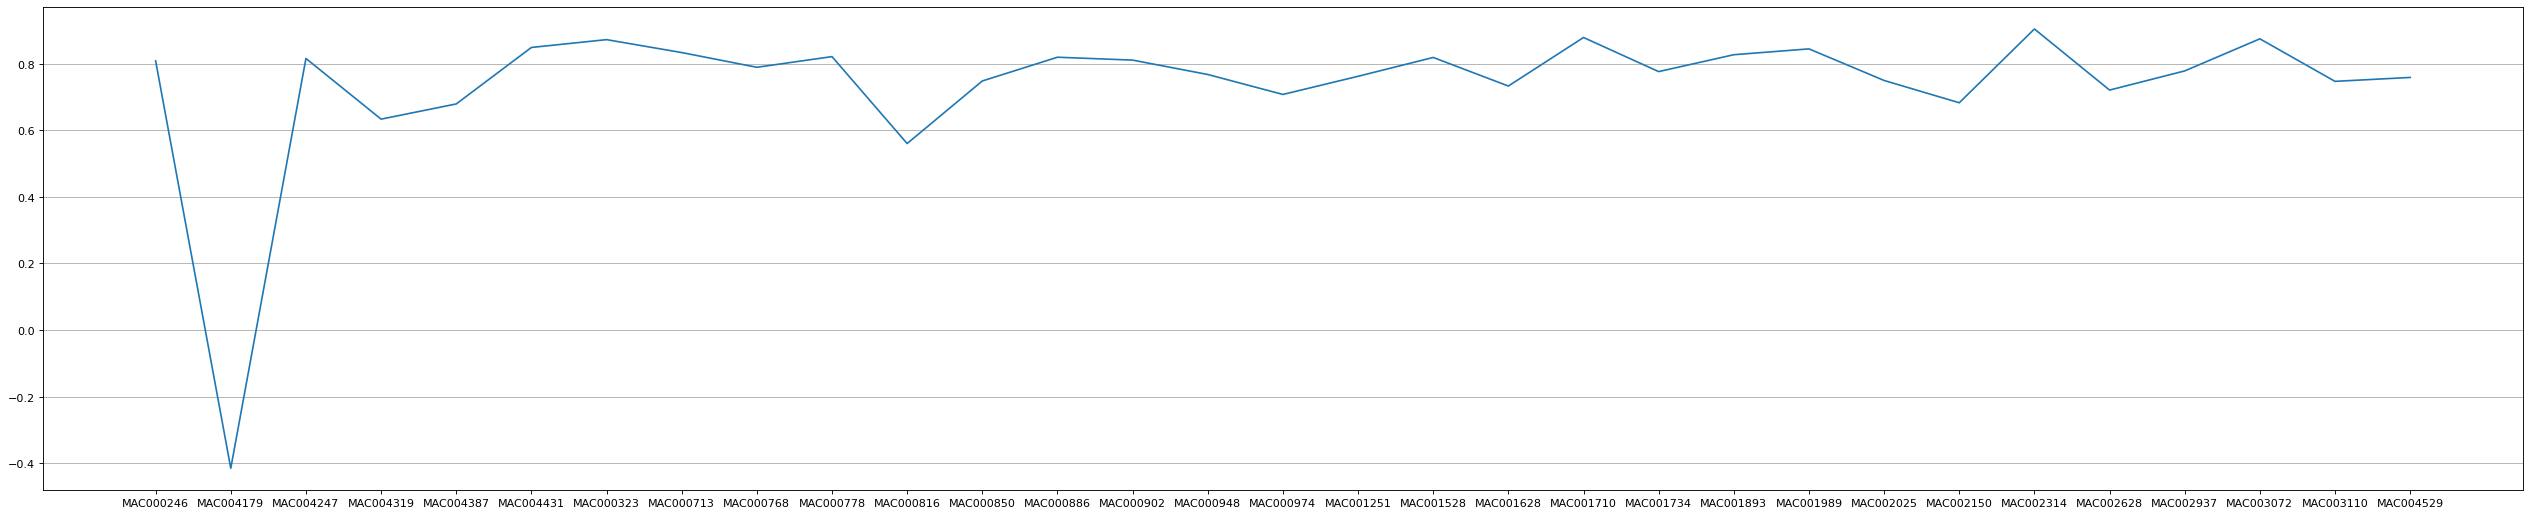

In [ ]:
### Among all model which house performed well 
k=pd.DataFrame(pd.DataFrame(np.array(list24),columns=user_list,index=user_list).sum(axis=0)/30,columns=["sum"])
figure(figsize=(40, 8), dpi=80)
plt.plot( k.index,k["sum"].values)
plt.grid(axis='y',)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.


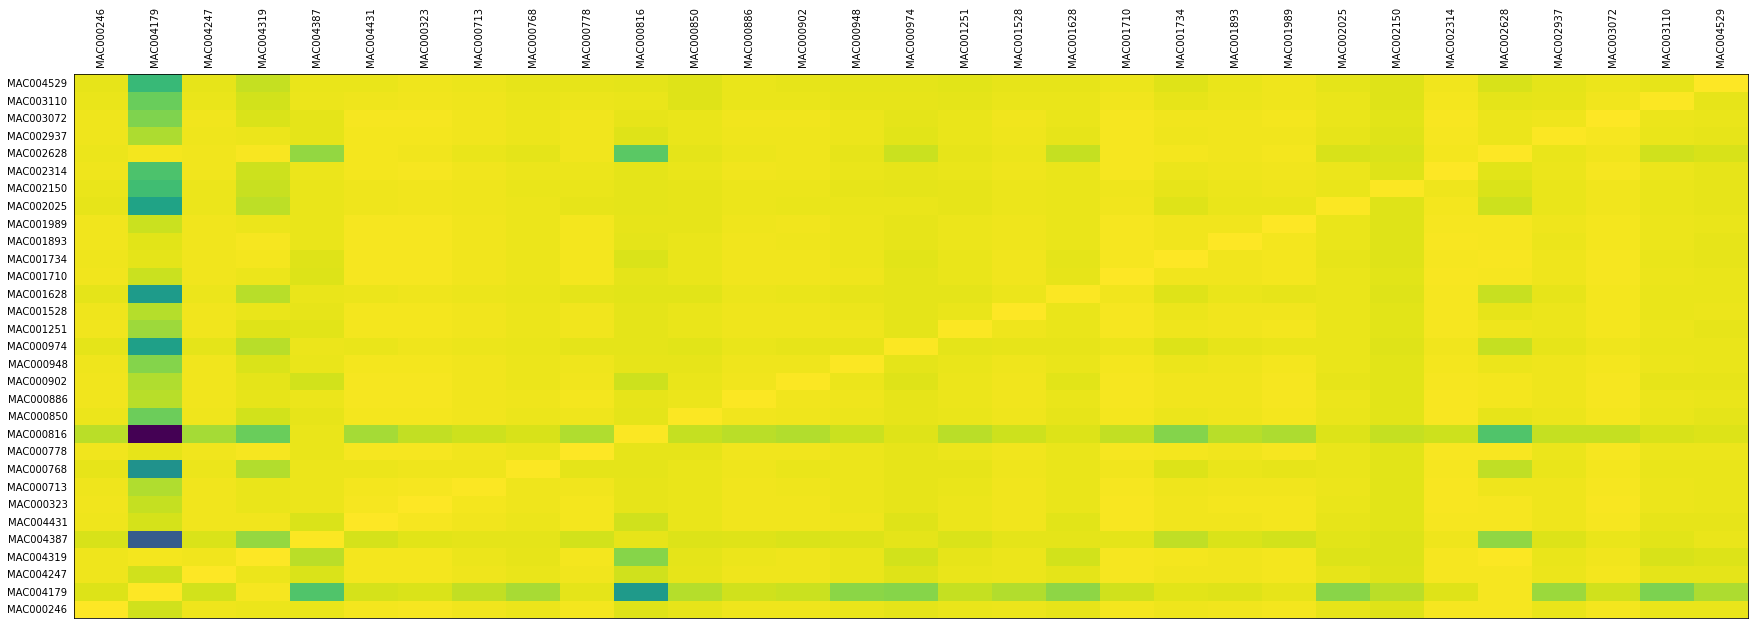

In [ ]:
xlabels=user_list
ylabels=user_list
data=pd.DataFrame(np.array(list24),columns=user_list,index=user_list)
fig, ax = plt.subplots(figsize=(30, 10))

ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)

ax.xaxis.tick_top()
plt.xticks(rotation=90)

ax.set_xticklabels(xlabels, minor=False)
ax.set_yticklabels(ylabels, minor=False)
heatmap = ax.pcolor(data)

ax = plt.gca()

for t in ax.xaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False
for t in ax.yaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False

plt.show()

# Now using the user data with worst performance as test dataset
##And using all other data(30 users) in training set to compare which set of features perform better

#Feature Set 1 : 24 lag values and 6 other temporal features features

In [34]:
###30 Users used for training
final_df=dataset_hourly.drop(["MAC004179"],axis=1)
final_df

,MAC000246,MAC004247,MAC004319,MAC004387,MAC004431,MAC000323,MAC000713,MAC000768,MAC000778,MAC000816,...,MAC001893,MAC001989,MAC002025,MAC002150,MAC002314,MAC002628,MAC002937,MAC003072,MAC003110,MAC004529
hour,,,,,,,,,,,,,,,,,,,,,
2012-07-02 12:00,0.037,0.732,0.604,0.056,0.469,0.183,0.240,0.086,0.208,0.133,...,0.188,0.086,0.071,1.549,0.048,0.438,0.299459,0.534,0.090,0.068
2012-07-02 13:00,0.107,1.880,1.222,0.095,1.667,0.293,0.510,0.158,1.299,0.180,...,0.367,0.134,0.183,1.855,0.733,0.695,0.598919,1.227,0.178,0.147
2012-07-02 14:00,0.063,1.205,1.211,0.100,1.244,0.228,0.505,0.134,0.819,0.176,...,1.784,0.174,0.182,0.445,0.357,0.759,0.806459,1.694,0.177,0.137
2012-07-02 15:00,0.060,0.517,1.224,0.113,0.714,0.254,0.592,0.192,0.438,0.176,...,0.781,0.134,0.135,0.294,0.216,0.678,0.749000,1.666,0.220,0.146
2012-07-02 16:00,0.126,1.281,1.413,0.100,1.082,0.250,0.585,0.140,0.480,0.229,...,0.392,0.171,0.167,0.205,0.231,0.760,0.260000,1.376,0.180,0.141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-27 20:00,0.550,0.750,2.303,0.424,0.523,0.790,0.371,0.887,2.471,0.120,...,1.649,1.816,0.697,0.486,1.206,1.911,0.807000,1.845,0.684,0.901
2014-02-27 21:00,2.884,0.709,2.443,0.309,0.422,0.789,0.608,0.760,2.499,0.144,...,1.799,2.155,0.778,0.416,1.122,1.808,0.864000,1.830,0.881,0.618
2014-02-27 22:00,3.556,0.824,2.117,0.231,0.545,1.138,0.492,0.365,0.591,0.381,...,1.314,1.524,0.613,0.470,0.562,1.870,0.712000,1.335,0.430,0.440


In [35]:
##User with Worst performance from all 30 models in previous training : Used as test dataset
target_variable=dataset_hourly["MAC004179"].values
dataset_hourly["MAC004179"]

hour
2012-07-02 12:00    2.400
2012-07-02 13:00    5.115
2012-07-02 14:00    3.473
2012-07-02 15:00    4.644
2012-07-02 16:00    3.516
                    ...  
2014-02-27 20:00    6.733
2014-02-27 21:00    5.999
2014-02-27 22:00    5.703
2014-02-27 23:00    4.592
2014-02-28 0:00     2.149
Name: MAC004179, Length: 14533, dtype: float64

 Creating 30 features from each of 30 user and concatenating them on their columns will give us one dataset
This dataset will have user patterns to be learn from various user profiles

In [39]:
user_list.remove('MAC004179')
len(user_list)

30

In [103]:
X,y=data_loader(final_df.sort_index(ascending=False),train=1,user_list=list(user_list))

<ipython-input-102-5ab879a26cb4>:123: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  agg["weekoftheyear"]=agg.index.week


In [104]:
X_train=pd.concat(X)
X_train

,lag24,lag23,lag22,lag21,lag20,lag19,lag18,lag17,lag16,lag15,...,lag4,lag3,lag2,lag1,year,month,hour,day,weekday,weekoftheyear
2012-07-02 12:00:00,0.492,0.000,0.069,0.064,0.107,0.113,0.065,0.123,0.107,0.080,...,0.126,0.060,0.063,0.107,2012,7,12,2,0,27
2012-07-02 13:00:00,1.798,0.492,0.000,0.069,0.064,0.107,0.113,0.065,0.123,0.107,...,0.061,0.126,0.060,0.063,2012,7,13,2,0,27
2012-07-02 14:00:00,0.819,1.798,0.492,0.000,0.069,0.064,0.107,0.113,0.065,0.123,...,0.060,0.061,0.126,0.060,2012,7,14,2,0,27
2012-07-02 15:00:00,1.551,0.819,1.798,0.492,0.000,0.069,0.064,0.107,0.113,0.065,...,0.101,0.060,0.061,0.126,2012,7,15,2,0,27
2012-07-02 16:00:00,0.000,1.551,0.819,1.798,0.492,0.000,0.069,0.064,0.107,0.113,...,0.556,0.101,0.060,0.061,2012,7,16,2,0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-26 20:00:00,0.901,0.394,0.994,0.197,0.089,0.120,0.505,0.105,0.116,0.102,...,0.111,0.431,0.438,0.614,2014,2,20,26,2,9
2014-02-26 21:00:00,0.618,0.901,0.394,0.994,0.197,0.089,0.120,0.505,0.105,0.116,...,0.086,0.111,0.431,0.438,2014,2,21,26,2,9
2014-02-26 22:00:00,0.440,0.618,0.901,0.394,0.994,0.197,0.089,0.120,0.505,0.105,...,0.090,0.086,0.111,0.431,2014,2,22,26,2,9
2014-02-26 23:00:00,0.449,0.440,0.618,0.901,0.394,0.994,0.197,0.089,0.120,0.505,...,0.099,0.090,0.086,0.111,2014,2,23,26,2,9


In [48]:
y_train=pd.concat(y)
y_train

hour
2012-07-02 12:00    0.037
2012-07-02 13:00    0.107
2012-07-02 14:00    0.063
2012-07-02 15:00    0.060
2012-07-02 16:00    0.126
                    ...  
2014-02-26 20:00    1.085
2014-02-26 21:00    0.614
2014-02-26 22:00    0.438
2014-02-26 23:00    0.431
2014-02-27 0:00     0.389
Length: 435270, dtype: float64

In [105]:
X,y=data_loader(dataset_hourly.sort_index(ascending=False),train=1,user_list=["MAC004179"])

<ipython-input-102-5ab879a26cb4>:123: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  agg["weekoftheyear"]=agg.index.week


In [106]:
X_test=pd.DataFrame(X[0])
X_test

,lag24,lag23,lag22,lag21,lag20,lag19,lag18,lag17,lag16,lag15,...,lag4,lag3,lag2,lag1,year,month,hour,day,weekday,weekoftheyear
2012-07-02 12:00:00,4.341,0.000,5.683,5.156,4.594,3.013,4.853,5.116,3.855,5.591,...,3.516,4.644,3.473,5.115,2012,7,12,2,0,27
2012-07-02 13:00:00,4.918,4.341,0.000,5.683,5.156,4.594,3.013,4.853,5.116,3.855,...,3.886,3.516,4.644,3.473,2012,7,13,2,0,27
2012-07-02 14:00:00,3.307,4.918,4.341,0.000,5.683,5.156,4.594,3.013,4.853,5.116,...,7.203,3.886,3.516,4.644,2012,7,14,2,0,27
2012-07-02 15:00:00,2.492,3.307,4.918,4.341,0.000,5.683,5.156,4.594,3.013,4.853,...,5.004,7.203,3.886,3.516,2012,7,15,2,0,27
2012-07-02 16:00:00,0.000,2.492,3.307,4.918,4.341,0.000,5.683,5.156,4.594,3.013,...,4.617,5.004,7.203,3.886,2012,7,16,2,0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-26 20:00:00,6.733,3.549,7.088,5.288,3.903,4.670,4.619,5.632,4.198,3.529,...,4.045,3.744,4.862,4.819,2014,2,20,26,2,9
2014-02-26 21:00:00,5.999,6.733,3.549,7.088,5.288,3.903,4.670,4.619,5.632,4.198,...,3.903,4.045,3.744,4.862,2014,2,21,26,2,9
2014-02-26 22:00:00,5.703,5.999,6.733,3.549,7.088,5.288,3.903,4.670,4.619,5.632,...,3.984,3.903,4.045,3.744,2014,2,22,26,2,9
2014-02-26 23:00:00,4.592,5.703,5.999,6.733,3.549,7.088,5.288,3.903,4.670,4.619,...,3.824,3.984,3.903,4.045,2014,2,23,26,2,9


In [60]:
y_test=y[0].values

#Training model Random forest

In [61]:
regressor = RandomForestRegressor(n_estimators = 10, oob_score=True ,n_jobs=10,verbose=2)
# fit the regressor with x and y data
regressor.fit(X_train, y_train)



[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:  2.4min remaining:  5.7min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  2.5min finished


OOB Prediction score while training :  [0.267      0.129      0.17566667 ... 0.543      0.442      0.5276    ]


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [69]:
y_pred_train=regressor.oob_prediction_
training_performance=accuracie(y_pred_train,y_train,)

Mean Absolute Error (MAE)            : 0.2739613024072937
Mean Squared Error (MSE)             : 0.24540090819795238
Root Mean Squared Error (RMSE)       : 0.4953795597296606
Explained Variance Score             : 0.6226564082093433
R^2                                  : 0.6225158346498851


In [71]:
test_score=accuracie(y_pred,y_test)

Mean Absolute Error (MAE)            : 0.7322378741109026
Mean Squared Error (MSE)             : 1.041319242887245
Root Mean Squared Error (RMSE)       : 1.0204505097687222
Explained Variance Score             : 0.5156101440895482
R^2                                  : 0.5087208295012413


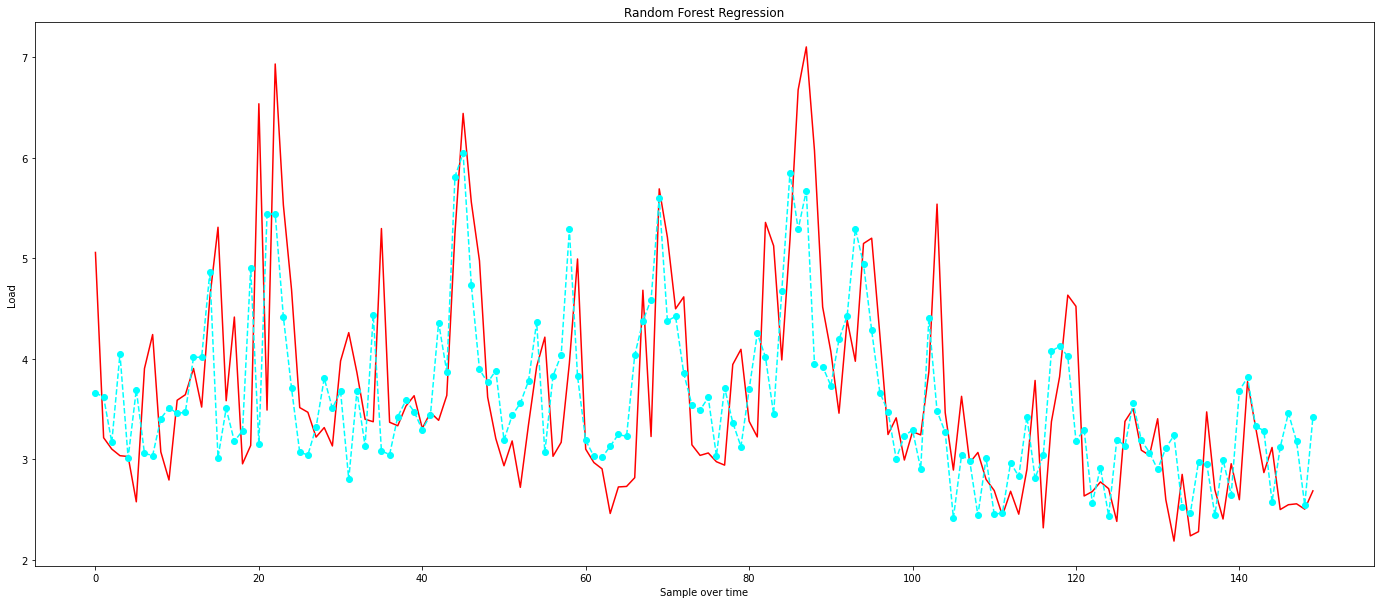

In [78]:
plot_please(y_pred[250:400],y_test[250:400])

This model has not shown satisfactory results with test dataset, the results are same as they were when one user data or 1/30th of train data was used for training.

# Feature set 2: Contains 6 temporal features and mean of last "N" hrs where N<24

In [79]:
X,y=data_loader(final_df.sort_index(ascending=False),train=2,user_list=list(user_list))

In [82]:
X_train=pd.concat(X)
X_train

,MeanLast_2H,MeanLast_3H,MeanLast_4H,MeanLast_5H,MeanLast_6H,MeanLast_7H,MeanLast_8H,MeanLast_9H,MeanLast_10H,MeanLast_11H,...,MeanLast_19H,MeanLast_20H,MeanLast_21H,MeanLast_22H,MeanLast_23H,day,month,hour,weekday,week
hour,,,,,,,,,,,,,,,,,,,,,
2012-07-02 12:00:00,0.144,0.207,0.267,0.207,0.454,0.144,0.267,0.454,0.615,2.271,...,0.514,0.615,1.171,2.271,3.985,28,2,0,4,9
2012-07-02 13:00:00,0.144,0.207,0.267,0.207,0.454,0.144,0.267,0.454,0.615,2.271,...,0.514,0.615,1.171,2.271,3.985,27,2,9,3,9
2012-07-02 14:00:00,0.123,0.207,0.267,0.207,0.454,1.027,0.267,0.454,0.615,2.271,...,0.514,0.615,1.171,2.271,3.985,27,2,8,3,9
2012-07-02 15:00:00,0.123,0.247,0.267,0.408,0.454,1.027,0.267,0.454,0.615,2.271,...,0.514,0.615,1.171,2.271,3.985,27,2,7,3,9
2012-07-02 16:00:00,0.187,0.247,0.348,0.408,0.454,1.027,5.373,0.454,0.615,2.271,...,0.514,0.615,1.171,2.271,3.985,27,2,6,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-27 20:00:00,1.519,2.092,2.408,2.647,3.599,3.641,3.808,4.313,2.647,3.989,...,4.552,2.647,4.875,6.389,4.047,2,7,16,0,27
2014-02-27 21:00:00,1.519,1.507,2.408,2.647,3.599,3.641,3.808,4.313,2.647,3.989,...,4.552,2.647,4.875,6.389,4.047,2,7,15,0,27
2014-02-27 22:00:00,0.889,1.507,2.408,2.647,3.599,3.641,3.808,4.313,2.647,1.128,...,4.552,2.647,4.875,1.128,4.047,2,7,14,0,27


In [85]:
y_train=pd.concat(y)
y_train

hour
2012-07-02 12:00    0.037
2012-07-02 13:00    0.107
2012-07-02 14:00    0.063
2012-07-02 15:00    0.060
2012-07-02 16:00    0.126
                    ...  
2014-02-27 20:00    0.901
2014-02-27 21:00    0.618
2014-02-27 22:00    0.440
2014-02-27 23:00    0.449
2014-02-28 0:00     0.239
Length: 435990, dtype: float64

In [87]:
regressor2 = RandomForestRegressor(n_estimators = 10, oob_score=True ,n_jobs=10,verbose=2)
# fit the regressor with x and y data
regressor2.fit(X_train, y_train)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:  5.1min remaining: 11.9min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  5.1min finished
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=10, n_jobs=10, oob_score=True, verbose=2)

In [90]:
y_pred_train=regressor2.oob_prediction_
training_performance=accuracie(y_pred_train,y_train)

Mean Absolute Error (MAE)            : 0.14869060988026284
Mean Squared Error (MSE)             : 0.09476197963686223
Root Mean Squared Error (RMSE)       : 0.30783433797557774
Explained Variance Score             : 0.8542505919229963
R^2                                  : 0.8541494297530651


In [91]:
X,y=data_loader(dataset_hourly.sort_index(ascending=False),train=2,user_list=["MAC004179"])

In [98]:
X_test=pd.DataFrame(X[0])
y_test=np.array(y[0])

In [99]:
y_pred=regressor2.predict(X_test)
test_performance=accuracie(y_pred,y_test)

Mean Absolute Error (MAE)            : 0.3670500883224576
Mean Squared Error (MSE)             : 0.2603128054338834
Root Mean Squared Error (RMSE)       : 0.5102085901216123
Explained Variance Score             : 0.8771076041259207
R^2                                  : 0.8771037857779427


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished


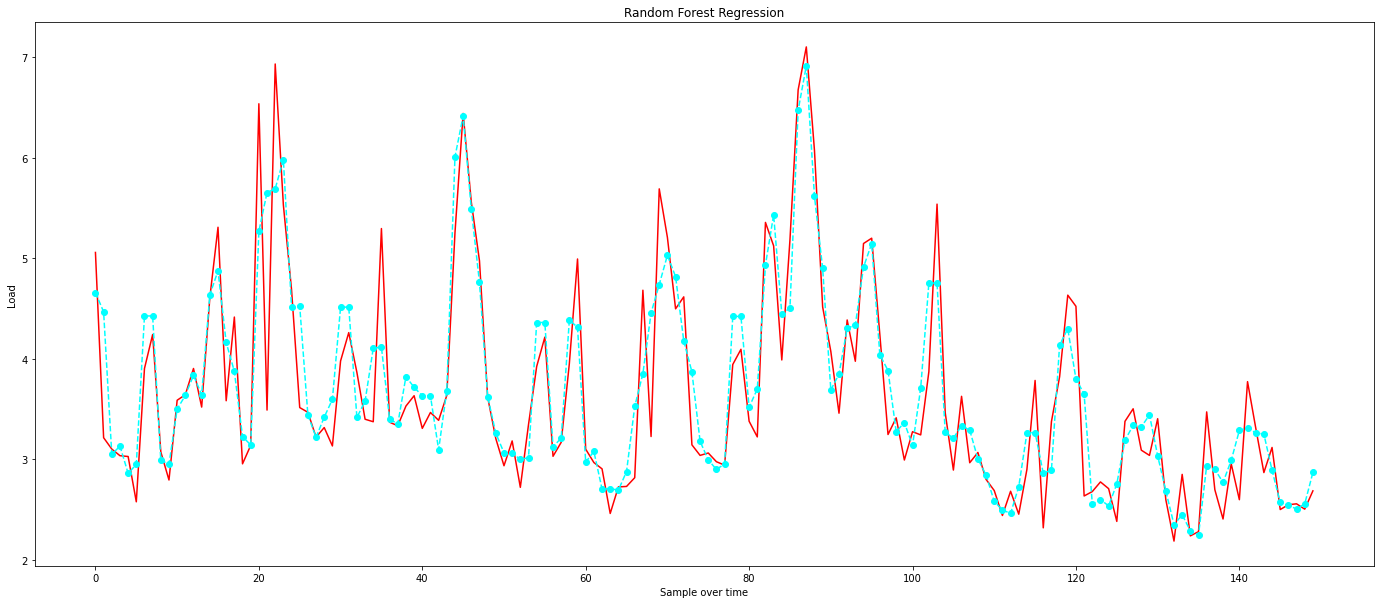

In [101]:
plot_please(y_pred[250:400],y_test[250:400])

For the same model architecture these set of features have got better performance and learned the patterns well while training.